In [1]:
"""
Use this notebook to calculate the volume of tailing pile or pond.
Code is prepared in the manner to calculate volume of seperate objects within the given raster.

The results of the analysis with the use of this notebook were published at the 
IV Academy of Cartography and Geoinformatics (https://akig.pwr.edu.pl/)

Code prepared by Wojciech Kaczan and Paweł Trybała. 
"""

'\nUse this notebook to calculate the volume of tailing pile or pond.\nCode is prepared in the manner to calculate volume of seperate objects within the given raster.\n\nThe results of the analysis with the use of this notebook were published at the \nIV Academy of Cartography and Geoinformatics (https://akig.pwr.edu.pl/)\n\nCode prepared by Wojciech Kaczan and Paweł Trybała. \n'

In [2]:
import fiona
from geocube.api.core import make_geocube
import geopandas as gpd
import matplotlib.pyplot as pyplot
import numpy as np
from osgeo import gdal
import rasterio
from rasterstats import zonal_stats
from shapely.geometry import Polygon

In [3]:
input_folder = "data/1_szklary"
output_folder = "results/1_szklary"

In [4]:
top_lidar_raster = 'data/2_szklary/lidar/szklary.tif'
bottom_contours = 'data/2_szklary/bottom/bottom_contours.shp'
boundaries = 'data/2_szklary/boundary/boundaries.shp'

In [5]:
dataset = gdal.Open(top_lidar_raster)

geotransform = dataset.GetGeoTransform()

pixel_size_x = geotransform[1]
pixel_size_y = -geotransform[5]  

print("Raster cell size is: {} x {}".format(pixel_size_x, pixel_size_y))

Raster cell size is: 1.0 x 1.0


c:\Users\wojciech.kaczan\AppData\Local\anaconda3\envs\dem-akig\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


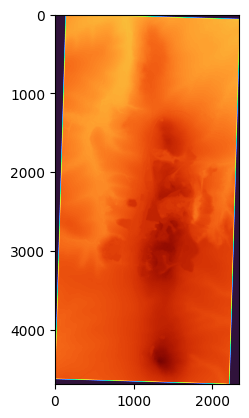

In [6]:
with rasterio.open(top_lidar_raster) as src_1:
    top_array = src_1.read(1)
    top_array[top_array==-9999] = 0
    pyplot.imshow(top_array, cmap='turbo')

<Projected CRS: EPSG:2180>
Name: ETRF2000-PL / CS92
Axis Info [cartesian]:
- x[north]: Northing (metre)
- y[east]: Easting (metre)
Area of Use:
- name: Poland - onshore and offshore.
- bounds: (14.14, 49.0, 24.15, 55.93)
Coordinate Operation:
- name: Poland CS92
- method: Transverse Mercator
Datum: ETRF2000 Poland
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

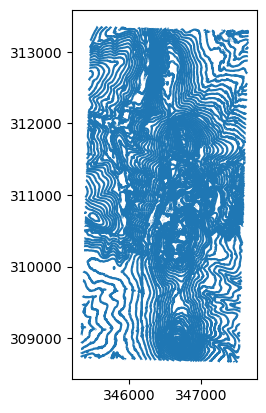

In [7]:
bottom_lines = gpd.read_file(bottom_contours)
bottom_lines.plot()
bottom_lines.crs

<Projected CRS: PROJCS["ETRS_1989_Poland_CS92",GEOGCS["ETRS89",DAT ...>
Name: ETRS_1989_Poland_CS92
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

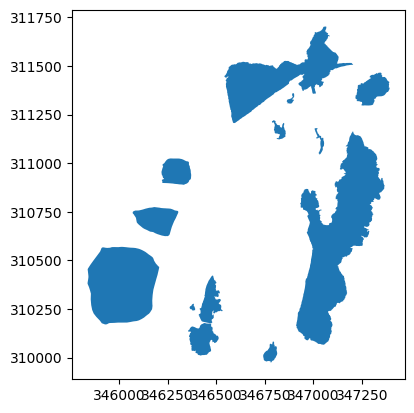

In [8]:
border = gpd.read_file(boundaries)
border.plot()
border.crs

In [9]:
bottom_lines.geometry = bottom_lines.geometry.buffer(0.5)
resolution = (pixel_size_x, pixel_size_y) 
geocube = make_geocube(vector_data=bottom_lines, measurements=['CONTOUR_1'], resolution=(pixel_size_x, pixel_size_y), interpolate_na_method='linear') # can try cubic

geocube['CONTOUR_1'].rio.to_raster(f'{output_folder}/bottom.tif')

In [10]:
with rasterio.open(f'{output_folder}/bottom.tif') as src:
    raster = src.read(1)

flipped_raster = raster[::-1, :]

with rasterio.open(
    f'{output_folder}/flipped_bottom.tif',
    'w',
    driver='GTiff',
    height=flipped_raster.shape[0],
    width=flipped_raster.shape[1],
    count=1,
    dtype=flipped_raster.dtype,
    crs=src.crs,
    transform=src.transform
) as dst:
    dst.write(flipped_raster, 1)

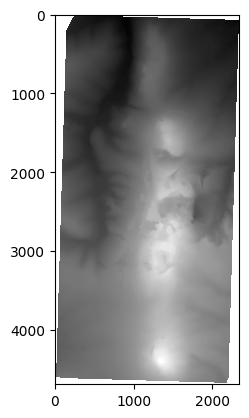

In [11]:
pyplot.imshow(flipped_raster, cmap='gray')
pyplot.show()

In [12]:
with rasterio.open(f'{output_folder}/flipped_bottom.tif') as src:
    left, bottom, right, top = src_1.bounds
    g = Polygon([(left, bottom), (right, bottom), (right, top), (left, top), (left, bottom)])
    out, out_transform = rasterio.mask.mask(src, [g], crop=True)
    kwargs = src_1.meta.copy()

with rasterio.open(f'{output_folder}/bottom_flipped_adjusted.tif', 'w', **kwargs) as cut_raster:
    cut_raster.write(out)

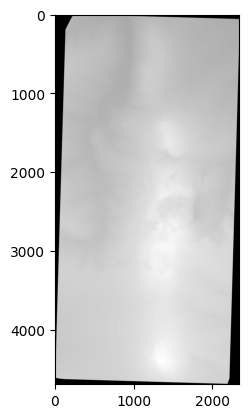

In [13]:
src_3 = rasterio.open(f'{output_folder}/bottom_flipped_adjusted.tif')
bottom_array_adjusted = src_3.read(1)
bottom_array_adjusted = np.where(np.isnan(bottom_array_adjusted), 0, bottom_array_adjusted)
pyplot.imshow(bottom_array_adjusted, cmap='gray')
pyplot.show()

In [14]:
with fiona.open(boundaries, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(f'{output_folder}/bottom_flipped_adjusted.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(f'{output_folder}/bottom_flipped_cropped.tif', "w", **out_meta) as dst:
    dst.write(out_image)

In [15]:
shp = fiona.open(boundaries, "r")

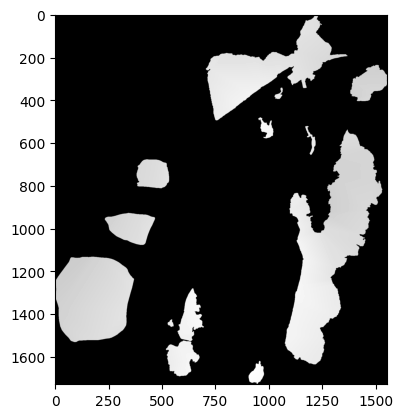

In [16]:
src_4 = rasterio.open(f'{output_folder}/bottom_flipped_cropped.tif')
tailings_cropped = src_4.read(1)
tailings_cropped[tailings_cropped==-9999] = 0

pyplot.imshow(tailings_cropped, cmap='gray')
pyplot.show()

In [17]:
# you're loading source file in every iteration

for i, shape in enumerate(shapes):
    with rasterio.open(f'{output_folder}/bottom_flipped_cropped.tif') as src:
        out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
        out_meta = src.meta
    
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    
    with rasterio.open(f'{output_folder}/bottom_cropped_{i}.tif', "w", **out_meta) as dest:
        dest.write(out_image)

In [18]:
#Calculate DoD
difference = top_array-bottom_array_adjusted

In [19]:
meta = src_3.meta 

with rasterio.open(f'{output_folder}/difference.tif', 'w', **meta) as dst:
    dst.write(difference, 1)

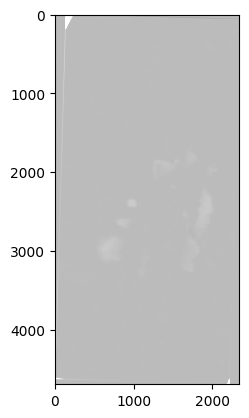

In [20]:
pyplot.imshow(difference, cmap='gray', vmax=100)
pyplot.show()

In [21]:
stats = zonal_stats(boundaries, f'{output_folder}/difference.tif')

c:\Users\wojciech.kaczan\AppData\Local\anaconda3\envs\dem-akig\Lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [22]:
dataset = gdal.Open(f'{output_folder}/difference.tif')

geotransform = dataset.GetGeoTransform()

pixel_size_x = geotransform[1]
pixel_size_y = -geotransform[5]  

print("Raster cell size is: {} x {}".format(pixel_size_x, pixel_size_y))

Raster cell size is: 1.0 x 1.0


In [23]:
#calculate volumes of each object

for i, shape in enumerate(shapes):
    with rasterio.open(f'{output_folder}/difference.tif') as src:
        out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
        out_meta = src.meta
    
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    
    with rasterio.open(f'{output_folder}/difference_cropped_{i}.tif', "w", **out_meta) as dest:
        dest.write(out_image)
    stats_single = zonal_stats(shape, f'{output_folder}/difference_cropped_{i}.tif')
    volume_single = (stats_single[0]['mean']-stats_single[0]['min'])*stats_single[0]['count']*(pixel_size_x*pixel_size_y)
    cx, cy = np.mean(shape.coordinates, axis=1)[0]
    print(f'Volume for area {i}: {volume_single:.2f}, centroid: {cx:.0f}, {cy:.0f}')

Volume for area 0: 225773.72, centroid: 346282, 310950
Volume for area 1: 224376.36, centroid: 346176, 310717
Volume for area 2: 1183456.50, centroid: 346032, 310408
Volume for area 3: 973740.27, centroid: 346882, 311475
Volume for area 4: 16356.65, centroid: 346824, 311174
Volume for area 5: 1883.99, centroid: 346886, 311330
Volume for area 6: 4592.24, centroid: 347031, 311118
Volume for area 7: 91975.99, centroid: 347301, 311384
Volume for area 8: 8515.19, centroid: 346783, 310029
Volume for area 9: 2684912.49, centroid: 347129, 310657
Volume for area 10: 86068.07, centroid: 346429, 310095
Volume for area 11: 77211.64, centroid: 346482, 310281
Volume for area 12: 1161.15, centroid: 346379, 310257


In [24]:
for i, shape in enumerate(shapes):
    with rasterio.open(f'{output_folder}/bottom_flipped_cropped.tif') as src:
        out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
        out_meta = src.meta
    
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    
    with rasterio.open(f'{output_folder}/bottom_cropped_{i}.tif', "w", **out_meta) as dest:
        dest.write(out_image)

In [25]:
for i, shape in enumerate(shapes):
    with rasterio.open(top_lidar_raster) as src:
        out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
        out_meta = src.meta
    
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    
    with rasterio.open(f'{output_folder}/top_cropped_{i}.tif', "w", **out_meta) as dest:
        dest.write(out_image)